In [1]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import EarthLocation
import pytz
from astroplan import Observer, FixedTarget
from astropy.utils.iers import conf
conf.auto_max_age = None
from astropy.coordinates import get_sun, get_moon, get_body
from astroplan import moon_illumination
from matplotlib import dates

import matplotlib.pyplot as plt
from astroplan.plots import plot_sky, plot_airmass
from astroplan import EclipsingSystem

from astroplan import download_IERS_A 
download_IERS_A()

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
plt.style.use('dark_background')

# Check which of Eric's systems are transiting

In [3]:
location = EarthLocation.of_site("Apache Point Observatory")

In [4]:
apo = Observer(location=location, timezone='US/Mountain',
               name="APO", description="Apache Point Observatory")

In [5]:
systems = [
    {
        "name": "K2-3",
        "ra": Angle("11h29m20.49s", unit=u.hourangle),
        "dec": Angle("-01d27m18.49s", unit=u.hourangle),
        "distance": 44.07270 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/K2-3%20d#planet_K2-3-d_collapsible",
    },
    {
        "name": "HD 260655",
        "ra":  99.2958 * u.deg,
        "dec": 17.5647 * u.deg,
        "distance": 44.07270 * u.pc,
        "link": "http://www.exoplanetkyoto.org/exohtml/HD_260655_b.html"
    },
    {
        "name": "TOI-1238",
        "ra": Angle("13 25 32.00", unit=u.hourangle),
        "dec": Angle("+68 50 10.00", unit=u.degree),
        "distance":  70.64 * u.pc,
        "link": "http://www.openexoplanetcatalogue.com/planet/TOI-1238%20b/"
    },
    {
        "name": "K2-138",
        "ra": Angle("23h15m47.77s", unit=u.hourangle),
        "dec": Angle("-10d50m59.06s", unit=u.hourangle),
        "distance": 202.585 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/k2-138"
    },
    {
        "name": "Kepler-1972",
        "ra": Angle("19h13m34.87s", unit=u.hourangle),
        "dec": Angle("+39d52m21.02s", unit=u.hourangle),
        "distance": 287.389 * u.pc,
        "link": "https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-1972"
    },
]
target_coords = [SkyCoord(ra=system["ra"], dec=system["dec"], distance=system["distance"]) for system in systems]

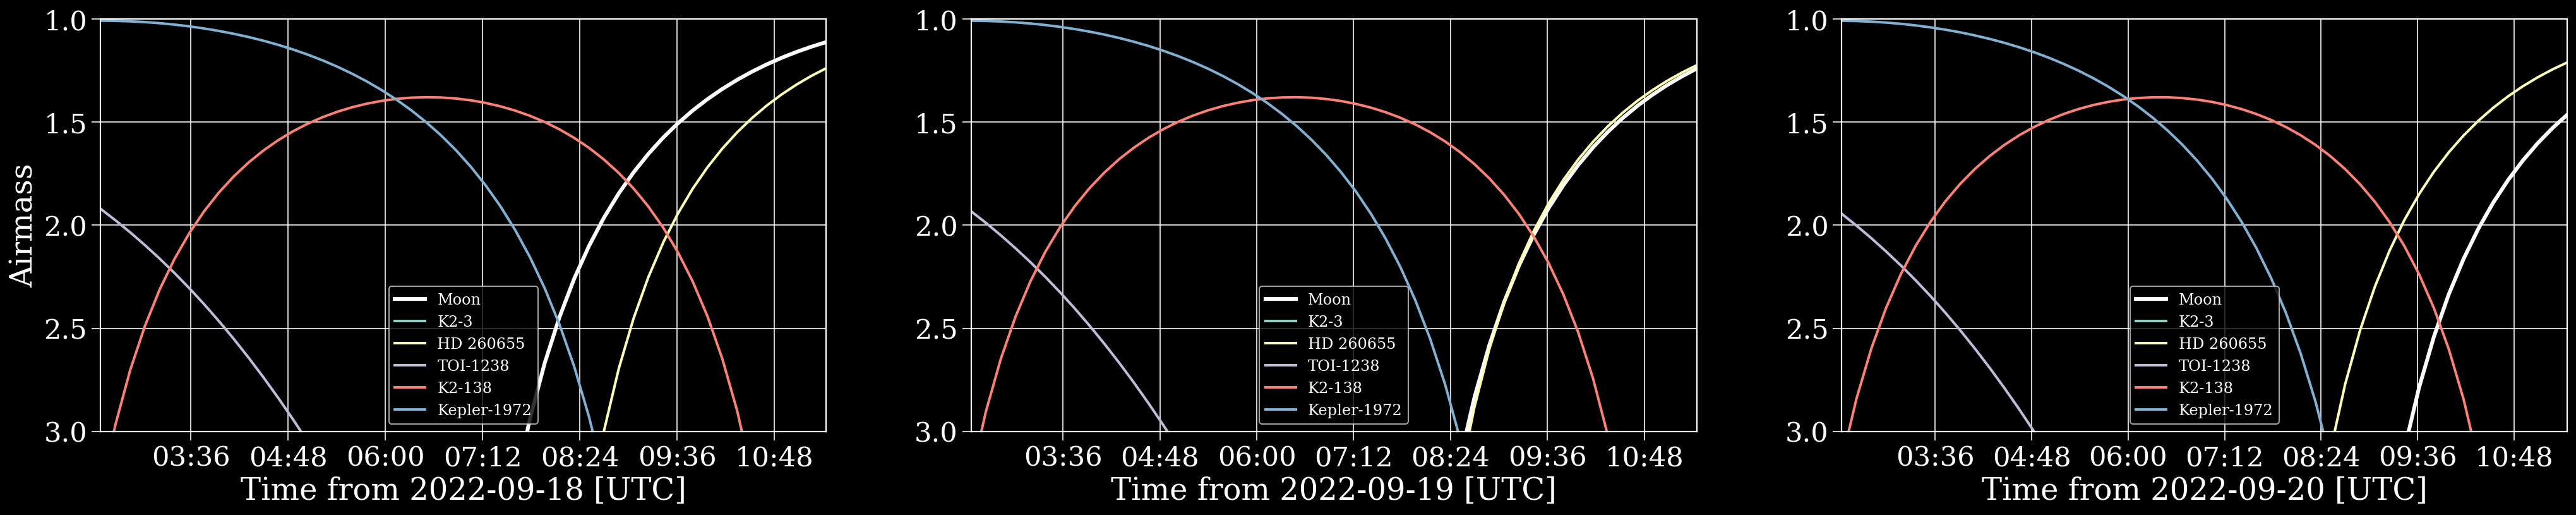

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(35, 6))

for day, ax in zip([18, 19, 20], axes):

    obs_time = Time(f"2022-09-{day}")
    sunset = apo.sun_set_time(obs_time, which='nearest')
    eve_twil = apo.twilight_evening_astronomical(obs_time, which='nearest')
    midnight = apo.midnight(obs_time, which='next')
    morn_twil = apo.twilight_morning_astronomical(obs_time, which='next')
    sunrise = apo.sun_rise_time(obs_time, which='next')

    t_start = eve_twil
    t_end = morn_twil
    t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 50)
    
    moon = get_moon(t_observe)
    moon_airmass = apo.altaz(t_observe, moon).secz
    
    ax.plot(t_observe[moon_airmass >= 1].plot_date, moon_airmass[moon_airmass >= 1],
            label="Moon", color="white", lw=3)

    for target, system in zip(target_coords, systems):
        # check if the target is up
        # print(apo.target_is_up(eve_twil, target, horizon=30*u.deg))
        # print(apo.target_is_up(midnight, target, horizon=30*u.deg))
        # print(apo.target_is_up(morn_twil, target, horizon=30*u.deg))

        if hasattr(t_observe, 'utcoffset') and use_local_tz:
            tzoffset = t_observe.utcoffset()
            tzname = t_observe.tzname()
            tzinfo = t_observe.tzinfo
        else:
            tzoffset = 0 * u.day
            tzname = 'UTC'
            tzinfo = None

        timetoplot = t_observe + tzoffset
        airmass = apo.altaz(t_observe, target).secz

        ax.plot(timetoplot[airmass >= 1].plot_date, airmass[airmass >= 1], label=system["name"], lw=2)
    
    ax.set_ylim(3, 1)
    ax.grid();

    xlo, xhi = (timetoplot[0]), (timetoplot[-1])
    ax.set_xlim([xlo.plot_date, xhi.plot_date])
    date_formatter = dates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(date_formatter)

    ax.legend(fontsize=0.5*fs)

    if ax == axes[0]:
        ax.set_ylabel("Airmass")
    ax.set_xlabel("Time from {0} [{1}]".format(min(timetoplot).datetime.date(), tzname))

plt.savefig("potential_systems.pdf", format="pdf", bbox_inches)

plt.show()

# Okay but is it transiting?

In [7]:
k1972b = EclipsingSystem(primary_eclipse_time=Time(2454944.8999, format="jd"),
                           orbital_period=7.54425 * u.day, duration=1.9 * u.hour,
                           name='kepler-1972b')
print(k1972b.next_primary_eclipse_time(Time("2022-09-18")))
print(k1972b.next_secondary_eclipse_time(Time("2022-09-18")))

['2022-09-18 14:50:05.160']
['2022-09-22 09:21:56.760']


In [8]:
k1972c = EclipsingSystem(primary_eclipse_time=Time(2454952.800, format="jd"),
                           orbital_period=11.3295 * u.day, duration=1.7 * u.hour,
                           name='kepler-1972c')
print(k1972c.next_primary_eclipse_time(Time("2022-09-18")))
print(k1972c.next_secondary_eclipse_time(Time("2022-09-18")))

['2022-09-24 15:27:18.600']
['2022-09-18 23:30:04.200']


In [9]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

In [10]:
results = NasaExoplanetArchive.query_object("K2-138")

UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]


In [11]:
latest_k2_138_planets = results[results["releasedate"] == "2021-03-04"]

In [12]:
k2_138_transits = [None for i in range(len(latest_k2_138_planets))]
for i in range(len(latest_k2_138_planets)):
    k2_138_transits[i] = EclipsingSystem(primary_eclipse_time=Time(latest_k2_138_planets["pl_tranmid"][i].value, format="jd"),
                                         orbital_period=latest_k2_138_planets["pl_orbper"][i].value * u.day,
                                         duration=latest_k2_138_planets["pl_trandur"][i].value * u.hour,
                                         name=latest_k2_138_planets["pl_name"][i])

In [17]:
latest_k2_138_planets

pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,disc_pubdate,disc_year,discoverymethod,disc_locale,disc_facility,disc_instrument,disc_telescope,disc_refname,ra,rastr,dec,decstr,glon,glat,elon,elat,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbperstr,pl_orblpererr1,pl_orblper,pl_orblpererr2,pl_orblperlim,pl_orblperstr,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxstr,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbinclstr,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtperstr,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenstr,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqtstr,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdepstr,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insolstr,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densstr,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandepstr,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmidstr,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandurstr,sy_kmagstr,sy_umag,sy_umagerr1,sy_umagerr2,sy_umagstr,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_rmagstr,sy_imag,sy_imagerr1,sy_imagerr2,sy_imagstr,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_zmagstr,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1magstr,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2magstr,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3magstr,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4magstr,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_gmagstr,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamagstr,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmagstr,pl_controv_flag,pl_tsystemref,st_metratio,st_spectype,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmagstr,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_rotpstr,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_projobliqstr,x,y,z,htm20,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvampstr,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radjstr,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radestr,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_ratrorstr,pl_ratdor,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,pl_trueobliqstr,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmagstr,rowupdate,pl_pubdate,st_refname,releasedate,dkin_flag,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratdorstr,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_impparstr,pl_cmassj,pl_cmassjerr1,pl_cmassjerr2,pl_cmassjlim,pl_cmassjstr,pl_cmasse,pl_cmasseerr1,pl_cmasseerr2,pl_cmasselim,pl_cmassestr,pl_massj,pl_massjerr1,pl_massjerr2,pl_massjlim,pl_massjstr,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim,pl_massestr,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassjstr,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassestr,pl_bmassprov,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim,pl_msinijstr,pl_msinie,pl_msinieerr1,pl_msinieerr2,pl_msinielim,pl_msiniestr,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffstr,st_met,st_meterr1,st_meterr2,st_metlim,st_metstr,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radvstr,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_vsinstr,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_lumstr,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_loggstr,st_age,st_ageerr1,st_ageerr2,st_agelim,st_agestr,st_mass,st_masserr1,st_masserr2,st_masslim,st_massstr,st_dens,st_denserr1,st_denserr2,st_denslim,st_densstr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radstr,ttv_flag,ptv_flag,tran_flag,rv_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,pul_flag,soltype,sy_snum,sy_pnum,sy_mnum,cb_flag,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_nnotes,sy_pm,sy_pmerr1,sy_pmerr2,sy_pmstr,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pmdecstr,sy_plx,sy_plxerr1,sy_plxerr2,sy_plxstr,sy_dist,sy_disterr1,sy_disterr2,sy_diststr,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmagstr,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmagstr,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_k

In [16]:
latest_k2_138_planets[["pl_orbper"]]

pl_orbper
d
float64
12.75758
5.40484
2.35321
3.56015
8.26147
41.96645


In [13]:
from astroplan import (PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint, LocalTimeConstraint)

obs_time = Time(f"2022-09-18")

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=30*u.deg)]

observable_transits = []

for i in range(len(k2_138_transits)):
    times = k2_138_transits[i].next_primary_eclipse_time(obs_time, n_eclipses=10)
    times = times[times < Time("2022-09-21")]
    if len(times) > 0:
        if np.ravel(is_event_observable(constraints, apo, target, times=times)).any():
            observable_transits.append({
                "name": k2_138_transits[i].name,
                "mid": times[0],
                "duration": k2_138_transits[i].duration
            })

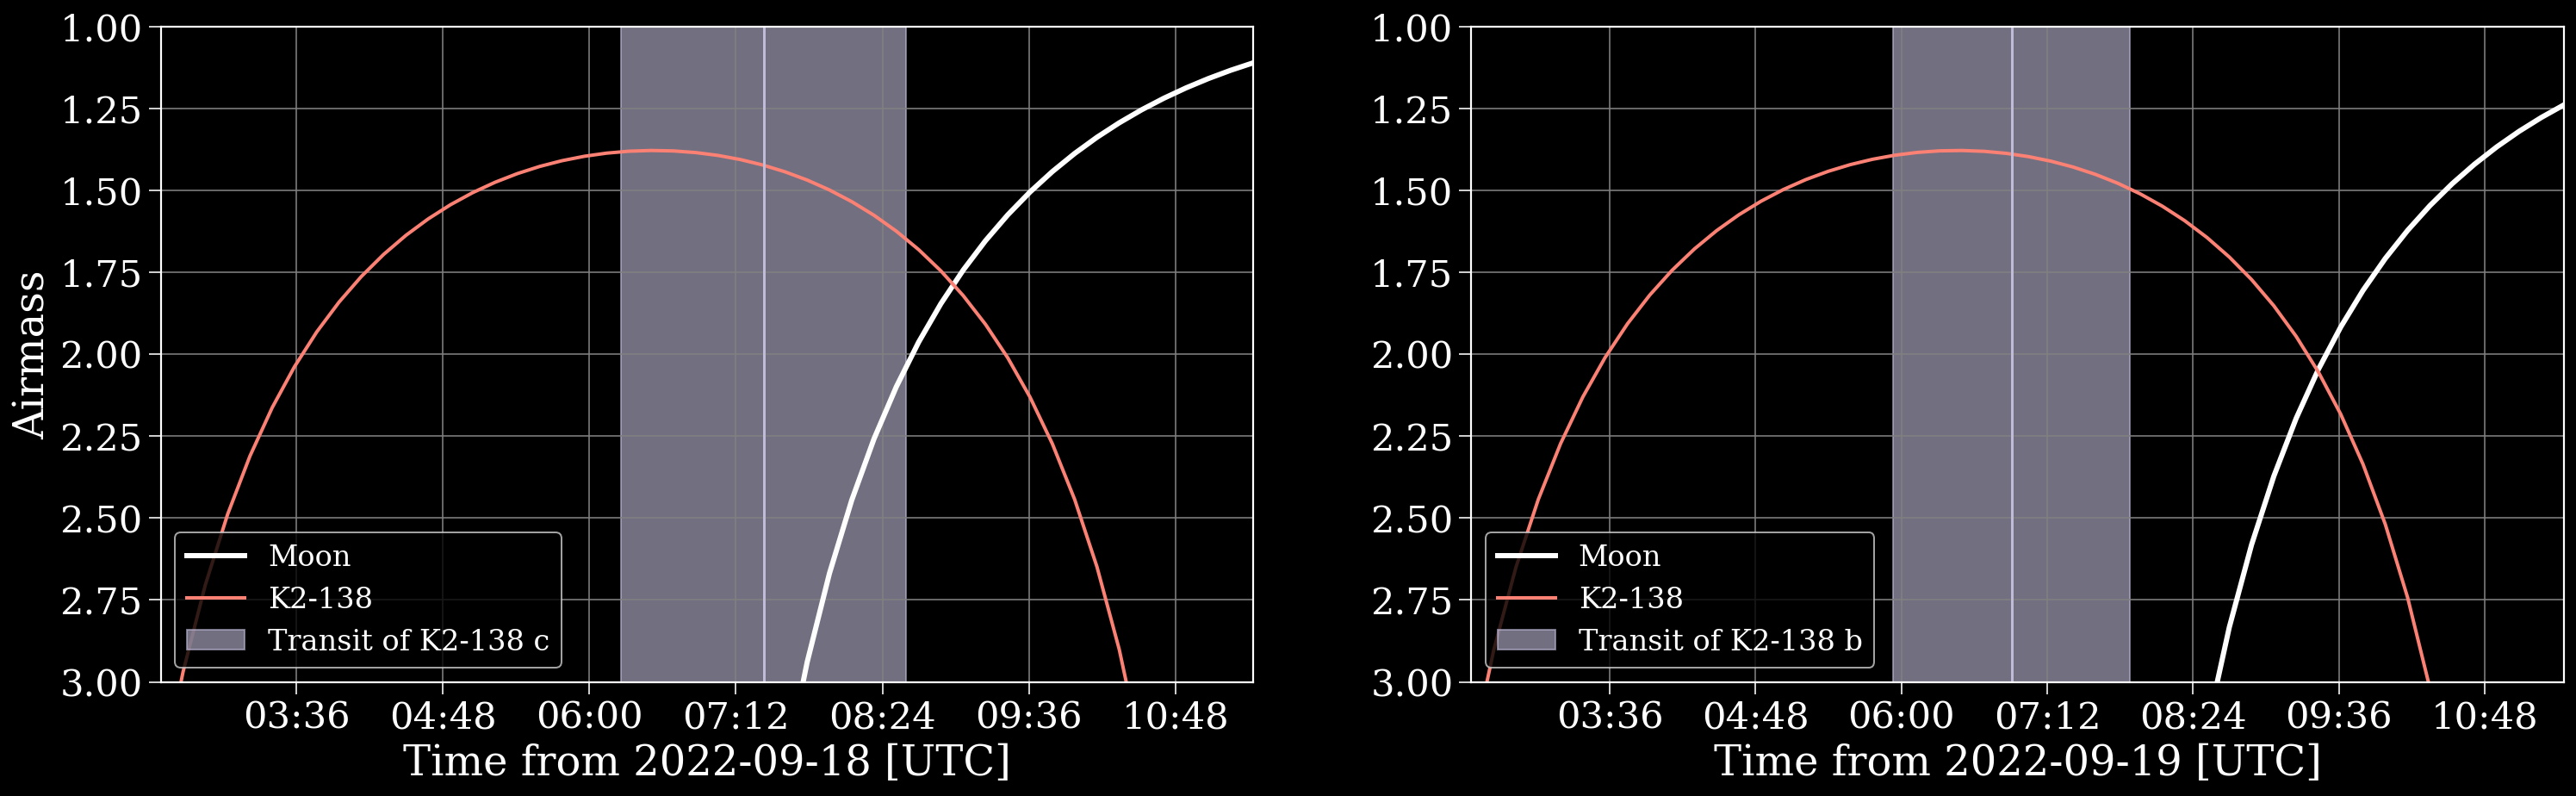

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(25, 7))

target, system = target_coords[-2], systems[-2]

for day, ax in zip([18, 19], axes):
    obs_time = Time(f"2022-09-{day}")
    sunset = apo.sun_set_time(obs_time, which='nearest')
    eve_twil = apo.twilight_evening_astronomical(obs_time, which='nearest')
    midnight = apo.midnight(obs_time, which='next')
    morn_twil = apo.twilight_morning_astronomical(obs_time, which='next')
    sunrise = apo.sun_rise_time(obs_time, which='next')

    t_start = eve_twil
    t_end = morn_twil
    t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 50)
    
    moon = get_moon(t_observe)
    moon_airmass = apo.altaz(t_observe, moon).secz
    
    ax.plot(t_observe[moon_airmass >= 1].plot_date, moon_airmass[moon_airmass >= 1],
            label="Moon", color="white", lw=3)

    if hasattr(t_observe, 'utcoffset') and use_local_tz:
        tzoffset = t_observe.utcoffset()
        tzname = t_observe.tzname()
        tzinfo = t_observe.tzinfo
    else:
        tzoffset = 0 * u.day
        tzname = 'UTC'
        tzinfo = None

    timetoplot = t_observe + tzoffset
    airmass = apo.altaz(t_observe, target).secz

    ax.plot(timetoplot[airmass >= 1].plot_date, airmass[airmass >= 1], label=system["name"], lw=2, color="C3")
    
    for transit in observable_transits:
        if transit["mid"] < t_observe[-1] and transit["mid"] > t_observe[0]:
            ax.axvline(Time(transit["mid"]).plot_date, color="C2")
            ax.axvspan((Time(transit["mid"]) - (transit["duration"] / 2)).plot_date,
                       (Time(transit["mid"]) + (transit["duration"] / 2)).plot_date, color="C2",
                       alpha=0.6, label=f"Transit of {transit['name']}")
    
    ax.set_ylim(3, 1)
    ax.grid(color="grey");

    xlo, xhi = (timetoplot[0]), (timetoplot[-1])
    ax.set_xlim([xlo.plot_date, xhi.plot_date])
    date_formatter = dates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(date_formatter)

    ax.legend(fontsize=0.7*fs, loc="lower left")

    if ax == axes[0]:
        ax.set_ylabel("Airmass")
    ax.set_xlabel("Time from {0} [{1}]".format(min(timetoplot).datetime.date(), tzname))

plt.show()